In [217]:
# imports
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import PercentFormatter
%matplotlib inline

# display settings
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 100)
pd.set_option('max_colwidth', 500)

---

### loading

In [173]:
# read the data
# index_col -> set index to 'Date'
# thousands -> recognize '1,000' as an int64 instead of a string
# na_values -> replace any '--' values with NA
# usecols -> only use relevant columns

dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d')

df = pd.read_csv('data/data.csv', parse_dates=['Date'], infer_datetime_format=True,
                index_col='Date', thousands=',', na_values='--',
                usecols=['Date', 'Activity Type', 'Distance', 'Calories', 'Time',
                            'Avg HR', 'Max HR', 'Aerobic TE', 'Avg Run Cadence', 'Max Run Cadence',
                            'Avg Pace', 'Best Pace', 'Total Ascent', 'Total Descent',
                            'Avg Stride Length', 'Min Elevation', 'Max Elevation'])

# hide HH:MM:SS
df.index = df.index.normalize()

---

### exploring

In [178]:
# take a peek!
df.head(3)

,Activity Type,Distance,Calories,Time,Avg HR,Max HR,Aerobic TE,Avg Run Cadence,Max Run Cadence,Avg Pace,Best Pace,Total Ascent,Total Descent,Avg Stride Length,Min Elevation,Max Elevation
Date,,,,,,,,,,,,,,,,
2022-10-27,Running,6.01,596,00:49:46,164,185,4.2,167,178,8:17,7:34,7.0,10.0,1.17,594.0,604.0
2022-10-26,Running,4.01,362,00:34:26,150,161,3.1,165,175,8:34,7:02,3.0,7.0,1.13,594.0,603.0
2022-10-23,Running,6.38,650,00:54:40,167,176,4.8,165,174,8:34,7:44,7.0,3.0,1.14,594.0,604.0


In [179]:
print(f"Since first getting this watch I completed {df.shape[0]} activities.")
print(f"But my watch allowed for multiple activity types, including {df['Activity Type'].unique()}.")
print(f"{df[(df['Activity Type'] == 'Cycling') | (df['Activity Type'] == 'Other')].shape[0]} of those activities weren't runs.")
print("So let's discard those values...")

Since first getting this watch I completed 789 activities.
But my watch allowed for multiple activity types, including ['Running' 'Other' 'Cycling' 'Treadmill Running'].
26 of those activities weren't runs.
So let's discard those values...


In [180]:
dropIndex = df[(df['Activity Type'] == 'Cycling') | (df['Activity Type'] == 'Other')].index
df.drop(dropIndex, inplace=True)

i also only want the data leading up to my 100 miler, which occurred february 5th, 2022. my first recorded run with this watch was april 9th, 2018. so for simplicity, i'll select the data from april 2018 to march 2022.

_it took almost four years of training for me to go from someone who __doesn't__ run to completing a 100 mile marathon... big things take time._

In [181]:
df.sort_values('Date', inplace=True)
df = df['2018-04-01':'2022-03-01'].copy(deep=True)

---

### nerding

In [184]:
print(f"It took me {(df.index.max() - df.index.min()).days:,} days to go from zero to running a hundred mile marathon.")
print(f"And I ran {df['Distance'].sum().round(2)} miles in training.")
print(f"Along the way burning {df['Calories'].sum():,} calories.")

It took me 1,398 days to go from zero to running a hundred mile marathon.
And I ran 5551.18 miles in training.
Along the way burning 556,701 calories.


what makes this data incredibly fun to explore is that each run for me is a memory. and since i never really ran before getting this watch, you can see how i developed through time as a runner. take a look at the time series of my runs below:

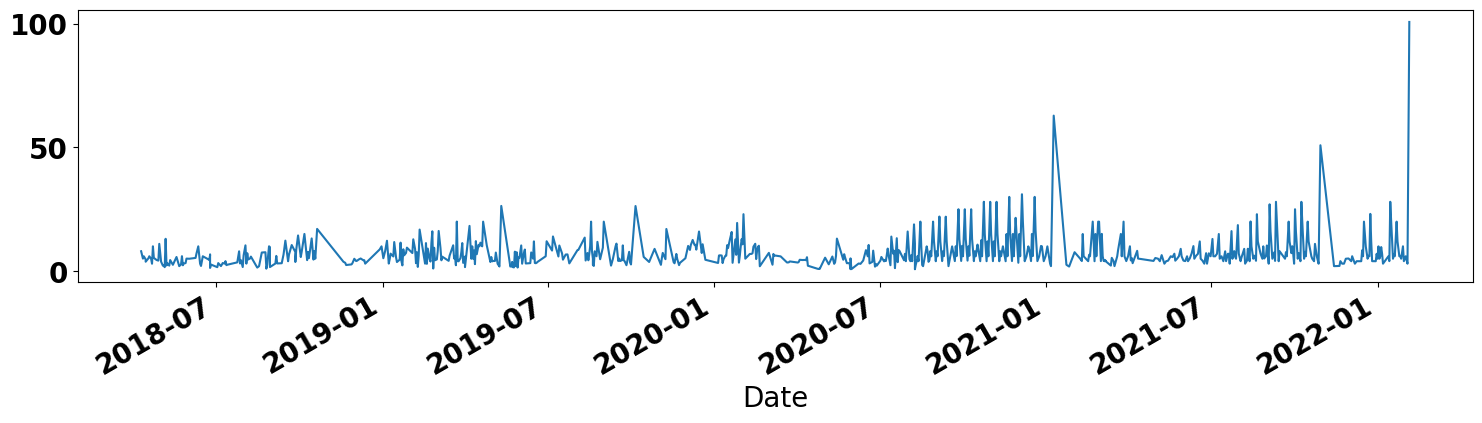

In [185]:
df['Distance'].plot(figsize=(18,4));

the build and consistency from july 2020 until that first 100k is really beautiful to see.

---

__insert bit about training plans...__

* images of my printed out training plans
* training completion percentages
* etc.

but what is also important is to see the days where I didn't run. i.e. **still need to add this in.**

####

| Date | Distance (Miles) | Distance (Kilometers) | Name |
| ------------------------- | :----: | :----: | :--------------------------: |
| May 6, 2018               | 13.10  | 21.08  | Providence Half Marathon |
| May 11, 2019              | 26.20  | 42.16  | Maine Coastal Marathon |
| October 6, 2019           | 26.20  | 42.16  | Milwaukee Lakefront Marathon |
| January 9, 2021           | 62.13  | 100.00 | Bandera 100K |
| April 10, 2021            | 62.13  | 100.00 | Zion 100K |
| October 30, 2021          | 50.00  | 80.46  | Chicago Lakefront 50 Miler |
| February 5, 2022          | 100.00 | 160.93 | Rocky Raccoon 100 Miler |


---

note the distribution of my mileage. my average run was about seven miles. but weekend long runs helped build my base and push my limit. those few ultras leading up my 100 miler helped as well:

In [186]:
print(f"My average run was {df['Distance'].mean().round(2)} miles.")

My average run was 7.58 miles.


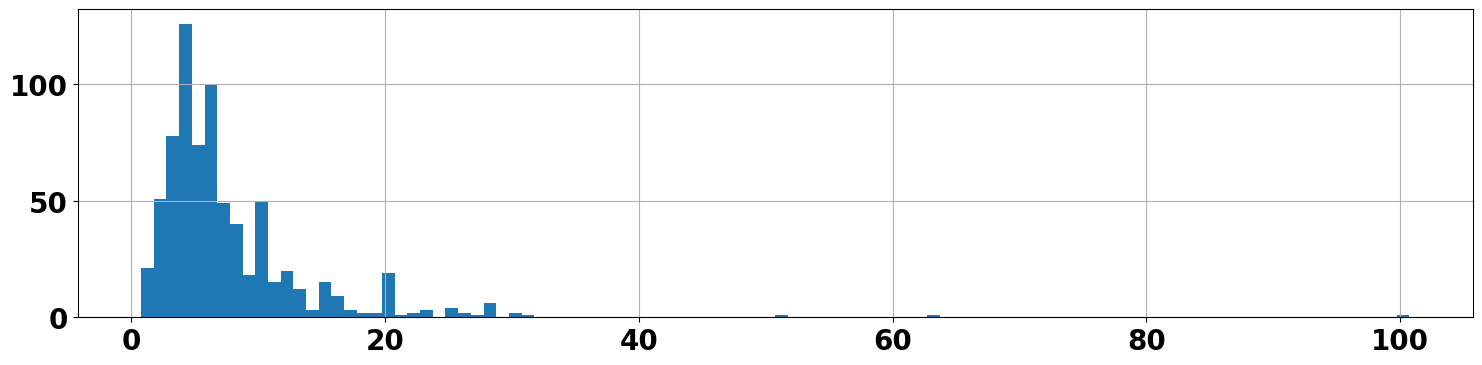

In [187]:
df['Distance'].hist(bins=100, figsize=(18,4));

from july 2020 onwards I took my training to a new level in both consistency _and_ distance as demonstrated in my weekly mileage:

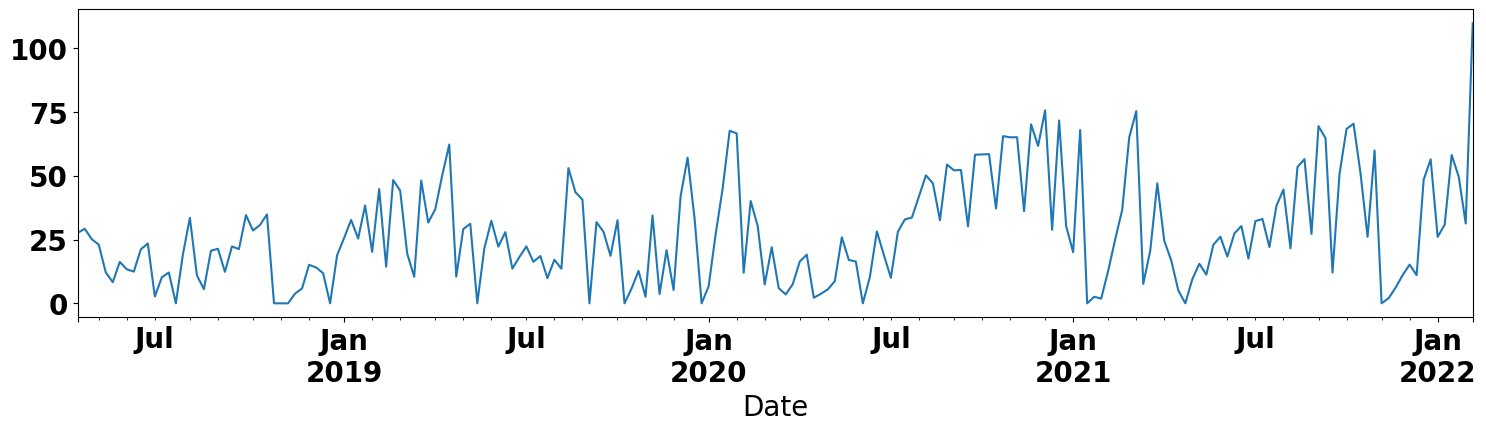

In [188]:
df.resample(rule='W')['Distance'].sum().plot(figsize=(18,4));

### Nerding Cont.
suss timestamp stuff (Time, Avg Pace, Best Pace) into usable information:

#### convert HH:MM:SS Time into total seconds

In [189]:
# note that now these are just the total number of seconds... #
df['Time_s'] = pd.to_timedelta(df['Time']).dt.total_seconds()

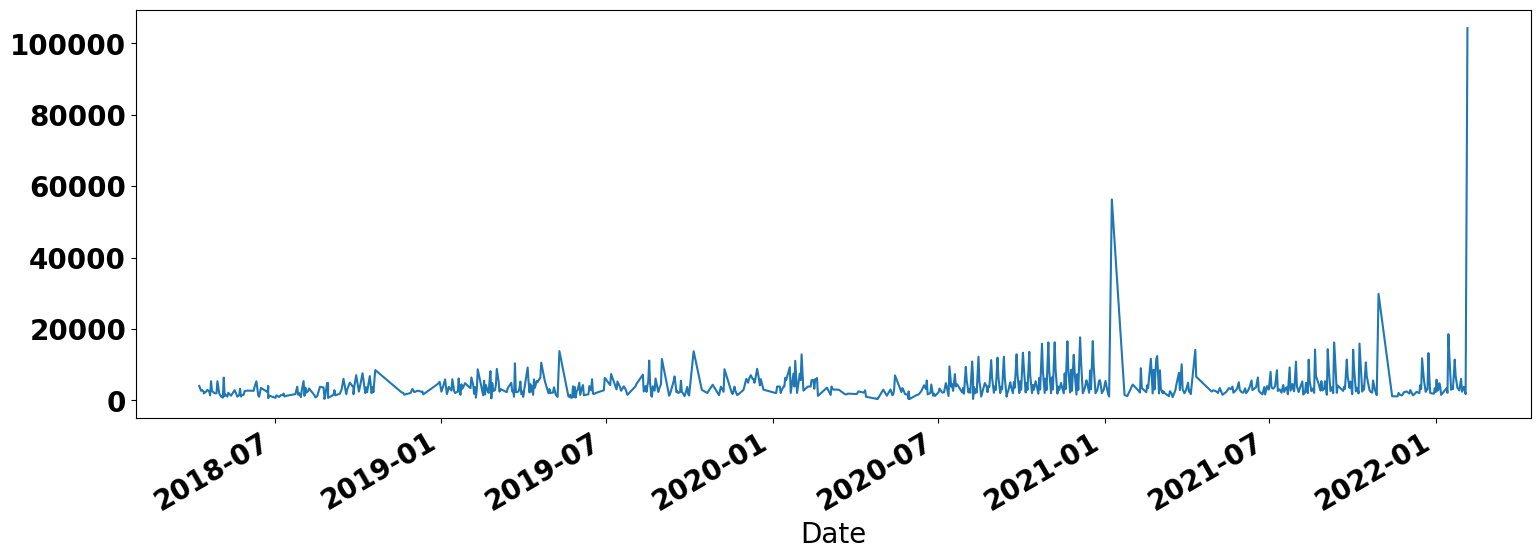

In [190]:
# time chart matches distance (as expected, at this scale)
df['Time_s'].plot(figsize=(18,6));

<div class="alert alert-block alert-warning">
i bet if i looked at time for similar distances i'd see that i'm getting faster...
</div>

#### How much time have I spent running?

60 seconds in a minute

3,600 seconds in an hour

simple calculation is to divide the total number of seconds by 3,600 to get the number of hours

In [218]:
print(f"How many hours of training did you have to do? {int(df['Time_s'].sum() % 3600)} hours")

How many hours of training did you have to do? 3169 hours


#### convert MM:SS Avg Pace and Best Pace into total seconds

In [193]:
df['Avg Pace_s'] = pd.to_timedelta('00:' + df['Avg Pace']).dt.total_seconds()
df['Best Pace_s'] = pd.to_timedelta('00:' + df['Best Pace']).dt.total_seconds()

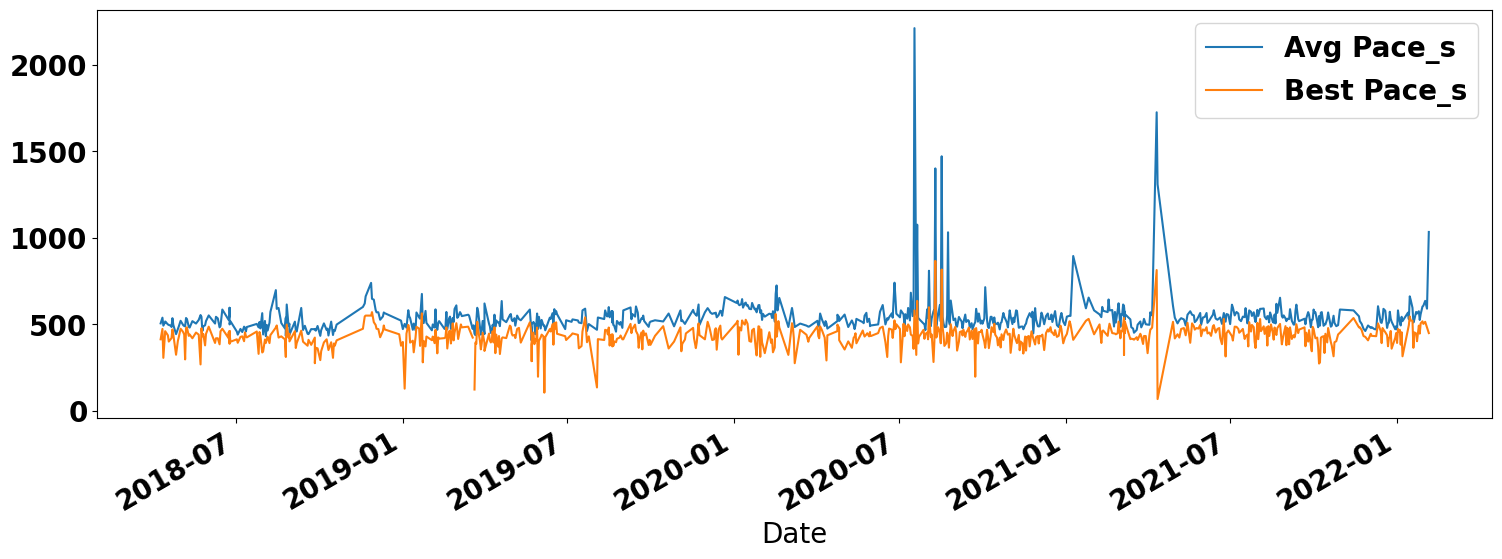

In [194]:
df[['Avg Pace_s', 'Best Pace_s']].plot(figsize=(18,6));

it's common for pacing information to get messed up because of a weak gps signal. for example, running in chicago the signal can be redirected running by the river or between tall buildings.

as expected, average pace spiked for ultra distances as there's often lots of walking to complete those events.

#### (Test) Plotting...

In [195]:
df.head(1)

,Activity Type,Distance,Calories,Time,Avg HR,Max HR,Aerobic TE,Avg Run Cadence,Max Run Cadence,Avg Pace,Best Pace,Total Ascent,Total Descent,Avg Stride Length,Min Elevation,Max Elevation,Time_s,Avg Pace_s,Best Pace_s
Date,,,,,,,,,,,,,,,,,,,
2018-04-09,Running,8.04,1088,01:07:47,172,187,5.0,161,175,8:26,6:54,203.0,205.0,1.19,69.0,139.0,4067.0,506.0,414.0


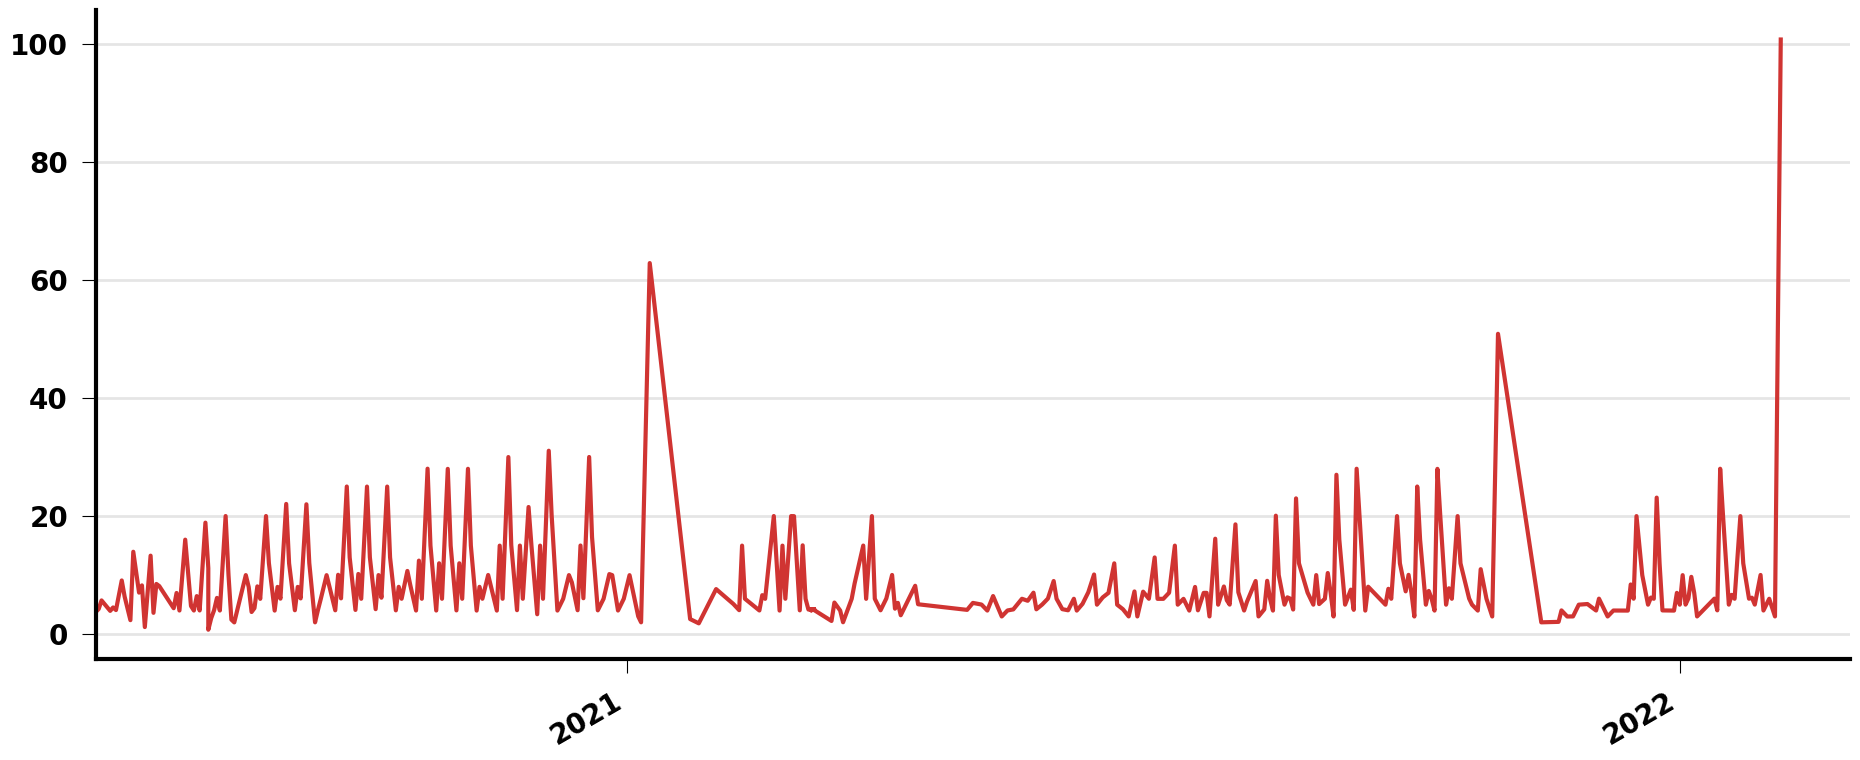

In [197]:
### Formatting the Line Plot
# Create a copy of the dataframe from 2020 -> 
df2020 = df['2020-01-01':].copy(deep=True)

# Then reset the index and then convert that column to a datetime object
df2020.reset_index(inplace=True)
pd.to_datetime(df2020['Date'])

plt.rcParams.update({'font.size': 20,
                    'font.weight': 'bold',
                    'font.family': 'DejaVu Sans',
                    'text.color': 'k'})

# Set x axis date minimums and maximums
datemin = np.datetime64('2020-07-01')
datemax = np.datetime64('2022-03-01')
                               
years = mdates.YearLocator()
months = mdates.MonthLocator()
yearsFmt = mdates.DateFormatter('%Y')

fig, ax = plt.subplots()
fig.set_size_inches(19, 8)

ax.plot(df2020['Date'], df2020['Distance'], color='#D03432', lw=3)

# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)

ax.set_xlim(datemin, datemax)
# ax.set_ylim([-5, 35])

# ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
# ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')

# rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them
fig.autofmt_xdate()

# Remove the spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['left'].set_linewidth(3)
ax.spines['left'].set_color('k')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_linewidth(3)
ax.spines['bottom'].set_color('k')

# Customize the major grid
ax.grid(axis='y', which='major', linestyle='-', linewidth='2', color='k', alpha=0.10)

ax.set_xlabel("", fontsize=0, color='#f5f5f5')

# Format Ticks
ax.tick_params(axis='x', which='minor', width=0)
ax.tick_params(axis='x', which='major', length=10, bottom=True, right=False, left=False, pad=10, color='k', labelcolor='k')
ax.xaxis.label.set_color('k')

ax.tick_params(axis='y', which='minor', length=0)
ax.tick_params(axis='y', which='major', length=10, bottom=True, right=False, left=True, pad=10, color='k', labelcolor='k')
ax.yaxis.label.set_color('k')

fig.tight_layout()

# OPTIONAL Incorporate 12 minor ticks for the year
# ax.minorticks_on()
# ax.xaxis.set_minor_locator(AutoMinorLocator(12))

#### testing plot with 0 values for days I didn't run:

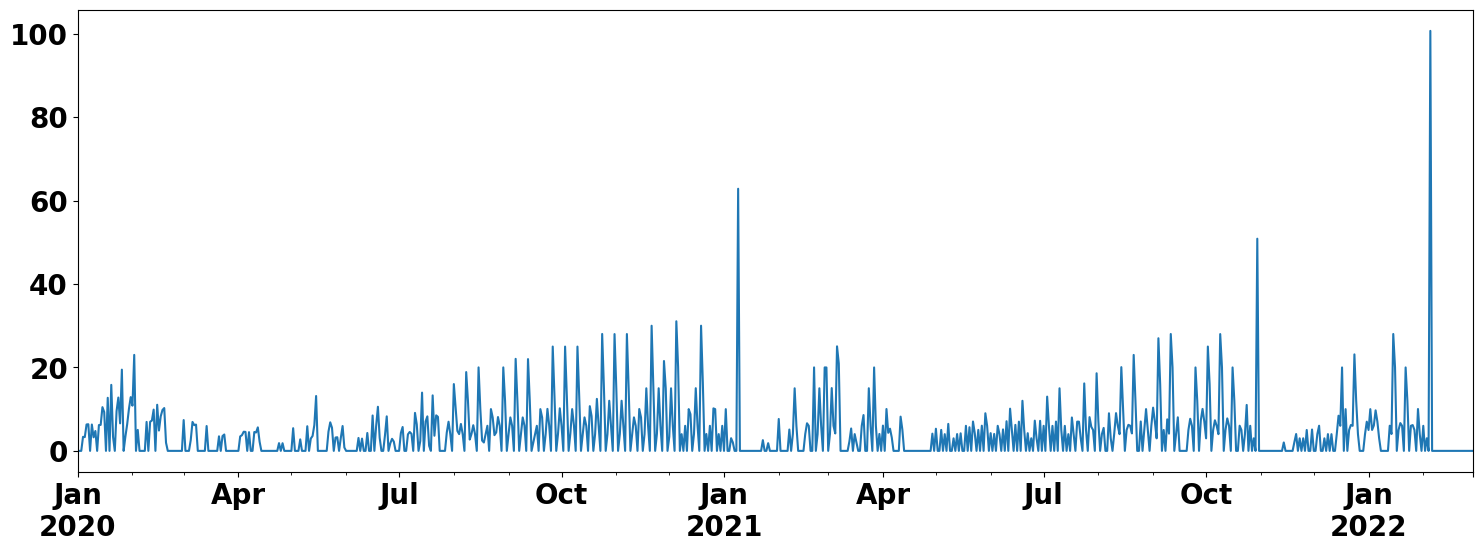

In [216]:
daily = pd.date_range('2020-01-01', '2022-03-01', freq='D')
df.groupby(df.index)['Distance'].sum().reindex(daily, fill_value=0).plot(figsize=(18,6));

---

#### Developing...

__notes:__

* Date also has the time of day... do I usually run in the morning or evening?

* I currently only have rows on days that I ran. For plotting purposes I'd also like to see days I didn't run for identifying rest days or bad streaks where maybe I was sick.

* My first run was April 9th 2018 and my 100 Miler was February 5th 2022. But I wasn't training for the 100 miler on April 9th, I was just training for the Providence half marathon. I can add colored sections to a chart to denote what race I was training for... Providence Half, Kennebunkport Full, Milwaukee Full, Zion 100K, Bandera 100K, Chicago 50M, Rocky Raccoon 100M. It's important to recognize this for calculating an accuracy score as well.

* Add some smoothing, maybe rolling average of 7 day mileage.

* Add jupyter lab widgets for interactions.

* Clean up formatting... Can you output python variables in markdown cells? Or is there a cleaner way to print text and variables togther?

* Incorporate more story... Images.

__Removed several columns:__
* Favorite
* Title
* Avg Vertical Ratio
* Avg Vertical Oscillation
* Avg Ground Contact Time
* Avg Run Cadence.1
* Max Run Cadence.1
* Training Stress Score®
* Avg Power
* Max Power
* Grit
* Flow
* Avg. Swolf
* Avg Stroke Rate
* Total Reps
* Dive Time
* Min Temp
* Surface Interval
* Decompression
* Max Temp
* Avg Pace t
* Best Lap Time
* Number of Laps
* Moving Time
* Elapsed Time

__Markdown Formatting Guide__
https://www.ibm.com/docs/en/watson-studio-local/1.2.3?topic=notebooks-markdown-jupyter-cheatsheet

# Old Plotting stuff

In [ ]:
### Formatting the Line Plot
# Create a copy of the dataframe from Jan 2016
df = s10y['2019-01-01':].copy(deep=True)
df = s10y.copy(deep=True)
df['percent'] = df['10Y:SME'] / 1000.

# Then reset the index and then convert that column to a datetime object
df.reset_index(inplace=True)
pd.to_datetime(df['Date'])

plt.rcParams.update({'font.size': 20,
                    'font.weight': 'bold',
                    'font.family': 'DejaVu Sans',
                    'text.color': 'k'})

# Set x axis date minimums and maximums
# datemin = np.datetime64('2019-07-01')
datemin = np.datetime64('2017-07-01')
datemax = np.datetime64('2020-10-01')
                               
years = mdates.YearLocator()
months = mdates.MonthLocator()
yearsFmt = mdates.DateFormatter('%Y')

fig, ax = plt.subplots()
fig.set_size_inches(19, 8)

ax1 = ax.twinx()

ax.plot(df['Date'], df['10Y:SME'], color='#D03432', lw=3)
ax1.plot(df['Date'], df['percent'], color='k', lw=0)

# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)

ax.set_xlim(datemin, datemax)
ax.set_ylim([-5, 35])
ax1.set_ylim([-0.50, 3.5])

# Format as percent
ax1.yaxis.set_major_formatter(PercentFormatter(decimals=3))

ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')

# rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them
fig.autofmt_xdate()

# Remove the spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['left'].set_linewidth(3)
ax.spines['left'].set_color('k')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_linewidth(3)
ax.spines['bottom'].set_color('k')

ax1.spines["left"].set_position(("axes", -0.1))
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(True)
ax1.spines['left'].set_linewidth(3)
ax1.spines['left'].set_color('k')
ax1.spines['bottom'].set_visible(True)
ax1.spines['bottom'].set_linewidth(3)
ax1.spines['bottom'].set_color('k')
ax1.yaxis.set_ticks_position('left')

# Customize the major grid
ax.grid(axis='y', which='major', linestyle='-', linewidth='2', color='k', alpha=0.10)

ax.set_xlabel("", fontsize=0, color='#f5f5f5')

# Format Ticks
ax.tick_params(axis='x', which='minor', width=0)
ax.tick_params(axis='x', which='major', length=10, bottom=True, right=False, left=False, pad=10, color='k', labelcolor='k')
ax.xaxis.label.set_color('k')

ax.tick_params(axis='y', which='minor', length=0)
ax.tick_params(axis='y', which='major', length=10, bottom=True, right=False, left=True, pad=10, color='k', labelcolor='k')
ax.yaxis.label.set_color('k')

ax1.tick_params(axis='x', which='minor', width=0)
ax1.tick_params(axis='x', which='major', length=10, bottom=True, right=False, left=False, pad=10, color='k', labelcolor='k')
ax1.xaxis.label.set_color('k')

ax1.tick_params(axis='y', which='minor', length=0)
ax1.tick_params(axis='y', which='major', length=10, bottom=True, right=False, left=True, pad=10, color='k', labelcolor='k')
ax1.yaxis.label.set_color('k')

ax.set_ylabel('Small Exchange Future', fontsize=20, fontweight='bold', color='#D03432')
ax1.set_ylabel('10-Year Treasury Note Yield', fontsize=20, fontweight='bold')
ax1.yaxis.set_label_position("left")

# fig.suptitle(10Y:SME', fontsize=22, fontweight='bold', y=0.91, x=0.11)
fig.tight_layout()
fig.savefig('s10y_negative_left_pct.png', transparent=True)

# OPTIONAL Incorporate 12 minor ticks for the year
# ax.minorticks_on()
# ax.xaxis.set_minor_locator(AutoMinorLocator(12))

In [ ]:
### Formatting the Line Plot
# Create a copy of the dataframe from Jan 2016
df = s10y['2019-01-01':].copy(deep=True)
df = s10y.copy(deep=True)
df['percent'] = df['10Y:SME'] / 1000.

# Then reset the index and then convert that column to a datetime object
df.reset_index(inplace=True)
pd.to_datetime(df['Date'])

plt.rcParams.update({'font.size': 20,
                    'font.weight': 'bold',
                    'font.family': 'DejaVu Sans',
                    'text.color': 'k'})

# Set x axis date minimums and maximums
# datemin = np.datetime64('2019-07-01')
datemin = np.datetime64('2017-07-01')
datemax = np.datetime64('2020-10-01')
                               
years = mdates.YearLocator()
months = mdates.MonthLocator()
yearsFmt = mdates.DateFormatter('%Y')

fig, ax = plt.subplots()
fig.set_size_inches(19, 8)

ax1 = ax.twinx()

ax.plot(df['Date'], df['10Y:SME'], color='#D03432', lw=3)
ax1.plot(df['Date'], df['percent'], color='k', lw=0)

# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)

ax.set_xlim(datemin, datemax)
ax.set_ylim([-5, 35])
ax1.set_ylim([-0.50, 3.5])

# Format as percent
ax1.yaxis.set_major_formatter(PercentFormatter(decimals=3))

ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')

# rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them
fig.autofmt_xdate()

# Remove the spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['left'].set_linewidth(3)
ax.spines['left'].set_color('k')
ax.spines['bottom'].set_visible(True)
ax.spines['bottom'].set_linewidth(3)
ax.spines['bottom'].set_color('k')

# ax1.spines["left"].set_position(("axes", -0.1))
ax1.spines['right'].set_visible(True)
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['right'].set_linewidth(3)
ax1.spines['right'].set_color('k')
ax1.spines['bottom'].set_visible(True)
ax1.spines['bottom'].set_linewidth(3)
ax1.spines['bottom'].set_color('k')
ax1.yaxis.set_ticks_position('right')

# Customize the major grid
ax.grid(axis='y', which='major', linestyle='-', linewidth='2', color='k', alpha=0.10)

ax.set_xlabel("", fontsize=0, color='#f5f5f5')

# Format Ticks
ax.tick_params(axis='x', which='minor', width=0)
ax.tick_params(axis='x', which='major', length=10, bottom=True, right=False, left=False, pad=10, color='k', labelcolor='k')
ax.xaxis.label.set_color('k')

ax.tick_params(axis='y', which='minor', length=0)
ax.tick_params(axis='y', which='major', length=10, bottom=True, right=False, left=True, pad=10, color='k', labelcolor='k')
ax.yaxis.label.set_color('k')

ax1.tick_params(axis='x', which='minor', width=0)
ax1.tick_params(axis='x', which='major', length=10, bottom=True, right=False, left=False, pad=10, color='k', labelcolor='k')
ax1.xaxis.label.set_color('k')

ax1.tick_params(axis='y', which='minor', length=0)
ax1.tick_params(axis='y', which='major', length=10, bottom=True, right=False, left=True, pad=10, color='k', labelcolor='k')
ax1.yaxis.label.set_color('k')

ax.set_ylabel('Small Exchange Future', fontsize=20, fontweight='bold', color='#D03432')
ax1.set_ylabel('10-Year Treasury Note Yield', fontsize=20, fontweight='bold')
ax1.yaxis.set_label_position("right")

# fig.suptitle(10Y:SME', fontsize=22, fontweight='bold', y=0.91, x=0.11)
fig.tight_layout()
fig.savefig('s10y_negative_right_pct.png', transparent=True)

# OPTIONAL Incorporate 12 minor ticks for the year
# ax.minorticks_on()
# ax.xaxis.set_minor_locator(AutoMinorLocator(12))